In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import numpy as np

#data path 수정
os.chdir("C:\\Users\\Owner2\\Desktop\\G팔로미_vuno")
os.getcwd()

'C:\\Users\\Owner2\\Desktop\\G팔로미_vuno'

In [2]:
X=np.load('data_X_with_callback.npy')
y=np.load('data_y_with_callback.npy')

In [3]:
len(X)

2145

In [5]:
#train, validation set 분리
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2, random_state=123)

In [7]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    #featurewise_center=True, #center 중심 유지
    #featurewise_std_normalization=True, #normalization
    rotation_range=25.0,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #brightness_range=[0.2,1.0],
    zoom_range=[0.8,1.2],
    horizontal_flip=True) #수평방향 뒤집기

datagen.fit(X_train)

dgf=datagen.flow(X_train,y_train,batch_size=32)

In [8]:
from keras import models, layers
from keras import Input
from keras.applications import VGG16
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

model = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))
model.trainable = True
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
#customizing my layers
additional_model = models.Sequential()
additional_model.add(model)
additional_model.add(layers.Dropout(0.3))
additional_model.add(layers.Flatten())
additional_model.add(layers.Dense(2048, activation='relu'))
additional_model.add(layers.Dense(1024, activation='relu'))
additional_model.add(layers.Dense(4, activation='softmax'))

additional_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              51382272  
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 4100      
Total params: 68,199,236
Trainable params: 68,199,236
Non-trainable params: 0
__________________________________________

In [10]:
def f1score(precision, recall):
    _f1score = ( 2 * recall * precision) / (recall + precision)
    
    # return a single tensor value
    return _f1score

In [11]:
# checkpoint = ModelCheckpoint(filepath='My_VGG_{epoch:03d}_{val_loss:.7f}.hdf5',monitor='loss', mode='min', save_best_only=True)
checkpoint = ModelCheckpoint(filepath='VGG16_1.hdf5', 
            monitor='val_loss', 
            mode='min', 
            save_best_only=True)

In [12]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [13]:
class_weight = {0: 0.8,
                1: 1,
                2: 1,
                3: 1}

In [14]:
history = additional_model.fit_generator(dgf, 
            steps_per_epoch=len(X_train)/32, 
            epochs=100, 
            validation_data=(X_val,y_val), 
            validation_steps=len(X_val)/32, 
            callbacks=[checkpoint],
            class_weight=class_weight)

Epoch 1/100
54/53 [==============================] - 21s 386ms/step - loss: 1.2338 - acc: 0.3328 - auc: 0.5318 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1score: 0.1004 - val_loss: 1.3703 - val_acc: 0.3893 - val_auc: 0.5716 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1score: 0.1014
Epoch 2/100
54/53 [==============================] - 14s 254ms/step - loss: 1.1839 - acc: 0.4073 - auc: 0.5948 - precision: 0.1550 - recall: 0.0016 - f1score: 0.1074 - val_loss: 1.2295 - val_acc: 0.4569 - val_auc: 0.6173 - val_precision: 0.5678 - val_recall: 0.0103 - val_f1score: 0.1163
Epoch 3/100
54/53 [==============================] - 15s 274ms/step - loss: 1.0786 - acc: 0.4598 - auc: 0.6437 - precision: 0.5616 - recall: 0.0253 - f1score: 0.1219 - val_loss: 1.1489 - val_acc: 0.4895 - val_auc: 0.6653 - val_precision: 0.5875 - val_recall: 0.0454 - val_f1score: 0.1259
Epoch 4/100
54/53 [==============================] - 15s 271ms/step - loss: 1.0449 - acc: 0.4784 - auc: 0.6802 - precisi

54/53 [==============================] - 15s 278ms/step - loss: 0.6641 - acc: 0.6789 - auc: 0.8332 - precision: 0.6721 - recall: 0.3940 - f1score: 0.1730 - val_loss: 1.3069 - val_acc: 0.4895 - val_auc: 0.8337 - val_precision: 0.6725 - val_recall: 0.3954 - val_f1score: 0.1412
Epoch 58/100
54/53 [==============================] - 15s 280ms/step - loss: 0.6354 - acc: 0.6952 - auc: 0.8342 - precision: 0.6729 - recall: 0.3969 - f1score: 0.1763 - val_loss: 1.2764 - val_acc: 0.5152 - val_auc: 0.8347 - val_precision: 0.6734 - val_recall: 0.3984 - val_f1score: 0.1424
Epoch 59/100
54/53 [==============================] - 15s 279ms/step - loss: 0.6546 - acc: 0.6900 - auc: 0.8353 - precision: 0.6740 - recall: 0.4000 - f1score: 0.1748 - val_loss: 1.3349 - val_acc: 0.4942 - val_auc: 0.8357 - val_precision: 0.6742 - val_recall: 0.4013 - val_f1score: 0.1390
Epoch 60/100
54/53 [==============================] - 15s 282ms/step - loss: 0.6258 - acc: 0.7051 - auc: 0.8362 - precision: 0.6749 - recall: 0.40

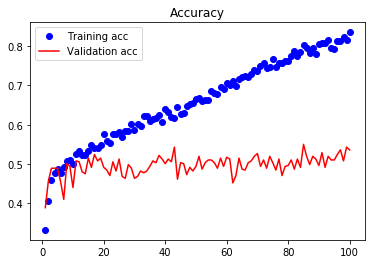

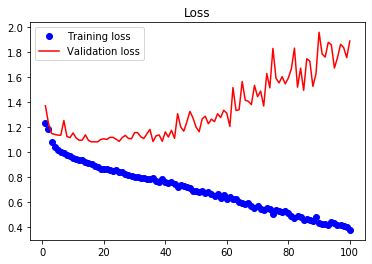

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [13]:
X_test=np.load('X_test.npy')
y_test=np.load('y_test.npy')

In [23]:
_loss, _acc, _auc, _precision, _recall, _f1score = additional_model.evaluate(X_val, y_val, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

429/429 [==============================] - 1s 3ms/step
loss: 1.889, accuracy: 0.536, auc: 0.872, precision: 0.716, recall: 0.508, f1score: nan


In [20]:
from keras.models import Model, load_model

new_model = models.load_model('VGG16_1.hdf5',compile=False)


new_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [18]:
_loss, _acc, _auc, _precision, _recall, _f1score = new_model.evaluate(X_val, y_val, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

429/429 [==============================] - 1s 3ms/step
loss: 1.082, accuracy: 0.492, auc: 0.770, precision: 0.591, recall: 0.283, f1score: 0.138


In [19]:
additional_model.save('VGG16_1.h5')